<a href="https://colab.research.google.com/github/jayantmhr/Jayant-Project-1/blob/main/Walk_Forward_Tuned_Momentum_%2B_RSI_Strategy_for_Multi_Asset_Backtesting_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📈 Analyzing AAPL...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-0cad9cbce1b7>:66: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252)


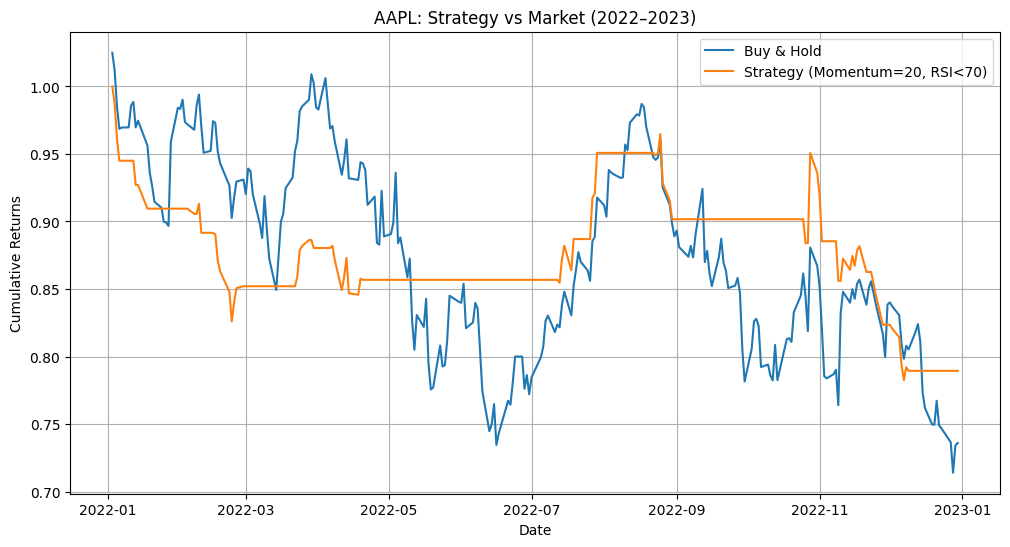

📈 Analyzing MSFT...


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-0cad9cbce1b7>:66: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252)


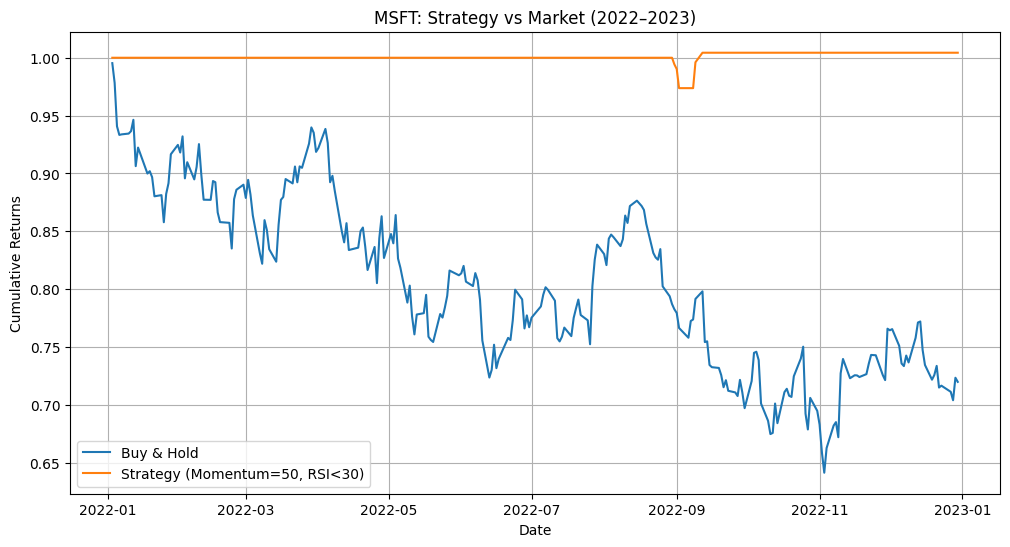

📈 Analyzing TSLA...


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-0cad9cbce1b7>:66: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252)


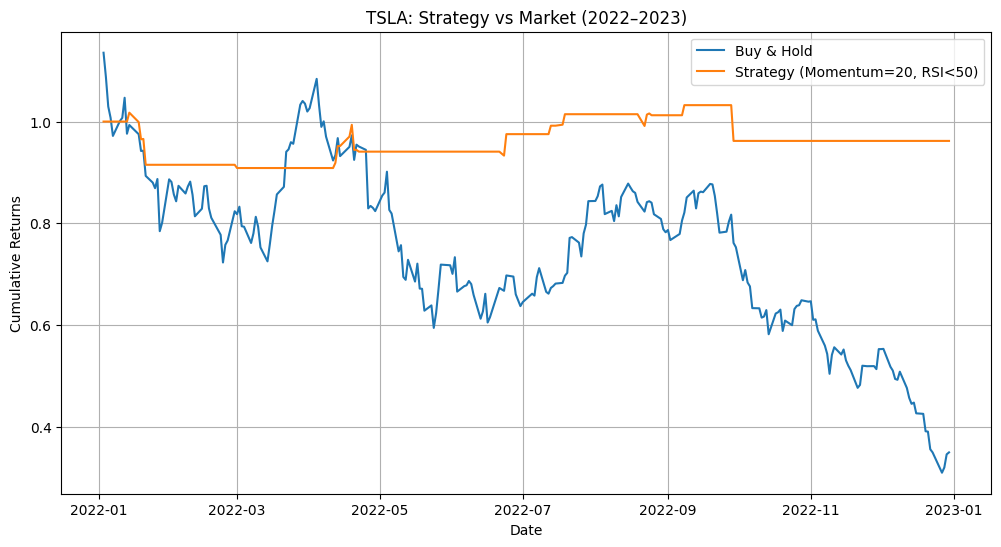

📈 Analyzing SHOP...


[*********************100%***********************]  1 of 1 completed
<ipython-input-1-0cad9cbce1b7>:66: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252)


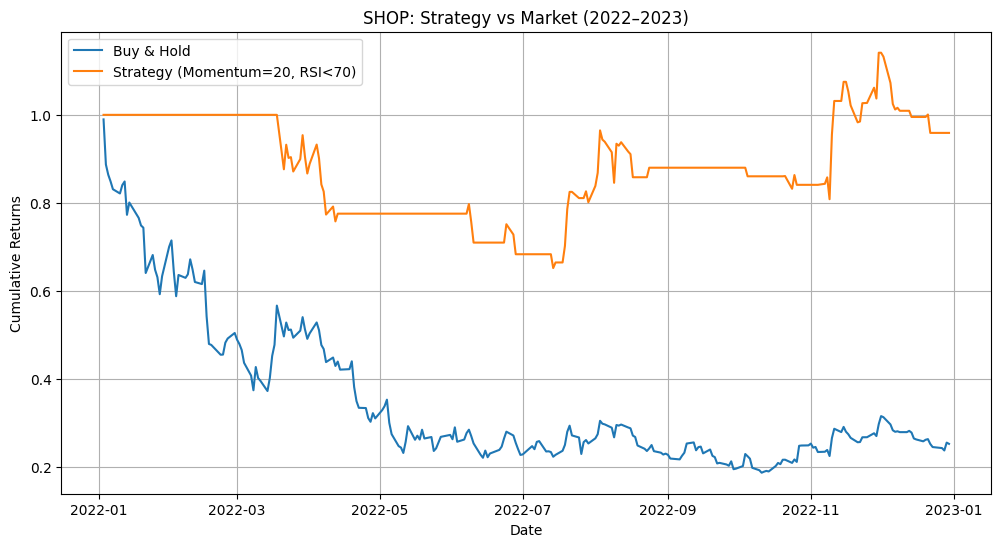

📊 Final Performance Summary:
  Ticker  Best Momentum Window  Best RSI Threshold  Sharpe Ratio  Volatility  \
0   AAPL                    20                  70         -1.39        0.16   
1   MSFT                    50                  30          0.16        0.03   
2   TSLA                    20                  50         -0.22        0.14   
3   SHOP                    20                  70          0.12        0.45   

   Max Drawdown  Final Strategy Return  Final Market Return  
0          0.22                   0.79                 0.74  
1          0.03                   1.00                 0.72  
2          0.11                   0.96                 0.35  
3          0.35                   0.96                 0.25  


In [1]:
# Install required packages (only needed in Google Colab)
!pip install yfinance matplotlib

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define stock tickers and date ranges
tickers = ['AAPL', 'MSFT', 'TSLA', 'SHOP']
train_start = '2018-01-01'
train_end = '2021-12-31'
test_start = '2022-01-01'
test_end = '2023-01-01'

# Define RSI calculation function
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = np.where(avg_loss == 0, np.inf, avg_gain / avg_loss)
    return 100 - (100 / (1 + rs))

# Define momentum and RSI parameter ranges
momentum_windows = [10, 20, 50]
rsi_thresholds = [30, 50, 70]

# Store all results here
final_results = []

# Process each stock
for ticker in tickers:
    print(f"📈 Analyzing {ticker}...")

    # Download data
    data = yf.download(ticker, start=train_start, end=test_end)
    price_col = 'Adj Close' if 'Adj Close' in data.columns else 'Close'

    # Basic preprocessing
    data['Returns'] = data[price_col].pct_change()
    data['RSI'] = calculate_rsi(data[price_col])

    train = data.loc[train_start:train_end].copy()
    test = data.loc[test_start:test_end].copy()

    if train.empty or test.empty:
        print(f"⚠️ Skipping {ticker}: missing data.")
        continue

    # Walk-forward tuning: find best momentum & RSI
    best_sharpe = -np.inf
    best_params = (None, None)

    for m in momentum_windows:
        for r in rsi_thresholds:
            temp = train.copy()
            temp[f'Momentum_{m}'] = data[price_col].pct_change(m)
            temp['Signal'] = np.where((temp[f'Momentum_{m}'] > 0) & (temp['RSI'] < r), 1, 0)
            temp['Strategy_Returns'] = temp['Signal'].shift(1) * temp['Returns']
            strat_ret = temp['Strategy_Returns'].dropna()

            if not strat_ret.empty:
                sharpe = strat_ret.mean() / strat_ret.std() * np.sqrt(252)
                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_params = (m, r)

    # Apply best strategy to test set
    m_opt, r_opt = best_params
    test[f'Momentum_{m_opt}'] = data[price_col].pct_change(m_opt)
    test['Signal'] = np.where((test[f'Momentum_{m_opt}'] > 0) & (test['RSI'] < r_opt), 1, 0)
    test['Strategy_Returns'] = test['Signal'].shift(1) * test['Returns']
    test['Cumulative_Market'] = (1 + test['Returns']).cumprod()
    test['Cumulative_Strategy'] = (1 + test['Strategy_Returns'].fillna(0)).cumprod()

    # Risk metrics
    strat_returns_test = test['Strategy_Returns'].dropna()
    sharpe_test = strat_returns_test.mean() / strat_returns_test.std() * np.sqrt(252) if not strat_returns_test.empty else np.nan
    volatility = strat_returns_test.std() * np.sqrt(252) if not strat_returns_test.empty else np.nan
    max_drawdown = (test['Cumulative_Strategy'].cummax() - test['Cumulative_Strategy']).max()

    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.plot(test['Cumulative_Market'], label='Buy & Hold')
    plt.plot(test['Cumulative_Strategy'], label=f'Strategy (Momentum={m_opt}, RSI<{r_opt})')
    plt.title(f'{ticker}: Strategy vs Market (2022–2023)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Store final metrics
    final_results.append({
        'Ticker': ticker,
        'Best Momentum Window': m_opt,
        'Best RSI Threshold': r_opt,
        'Sharpe Ratio': round(sharpe_test, 2) if not np.isnan(sharpe_test) else 'N/A',
        'Volatility': round(volatility, 2) if not np.isnan(volatility) else 'N/A',
        'Max Drawdown': round(max_drawdown, 2),
        'Final Strategy Return': round(test['Cumulative_Strategy'].iloc[-1], 2),
        'Final Market Return': round(test['Cumulative_Market'].iloc[-1], 2)
    })

# Display final summary table
summary_df = pd.DataFrame(final_results)
print("📊 Final Performance Summary:")
print(summary_df)